In [5]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the .mat file (adjust path to where you saved it)
file_path = '../data/raw/NASA/B0025.mat'  # Update this!
mat_data = sio.loadmat(file_path)
# Extract the battery data (usually under a key like 'B0005')
battery_data = mat_data['B0025'][0, 0]['cycle'][0]


Cycle 3: Raw capacity = [[array([[1.84701116]])]]
Cycle 5: Raw capacity = [[array([[1.84856543]])]]
Cycle 7: Raw capacity = [[array([[1.84711118]])]]
Cycle 9: Raw capacity = [[array([[1.84898376]])]]
Cycle 11: Raw capacity = [[array([[1.83701207]])]]
Cycle 15: Raw capacity = [[array([[1.81754921]])]]
Cycle 19: Raw capacity = [[array([[1.83986382]])]]
Cycle 22: Raw capacity = [[array([[1.84305956]])]]
Cycle 24: Raw capacity = [[array([[1.84018717]])]]
Cycle 26: Raw capacity = [[array([[1.82812656]])]]
Cycle 30: Raw capacity = [[array([[1.82535633]])]]
Cycle 34: Raw capacity = [[array([[1.82141806]])]]
Cycle 36: Raw capacity = [[array([[1.83031563]])]]
Cycle 38: Raw capacity = [[array([[1.81754916]])]]
Cycle 40: Raw capacity = [[array([[1.8109012]])]]
Cycle 42: Raw capacity = [[array([[1.80830326]])]]
Cycle 46: Raw capacity = [[array([[1.79280161]])]]
Cycle 50: Raw capacity = [[array([[1.81256315]])]]
Cycle 52: Raw capacity = [[array([[1.80777261]])]]
Cycle 54: Raw capacity = [[array([[1

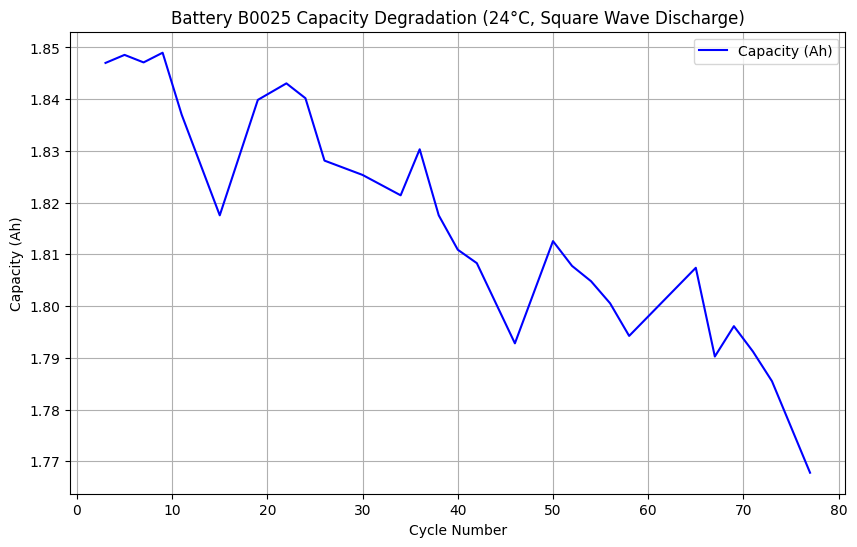

In [6]:
# Pull out capacity and cycle numbers
cycles = []
capacities = []
for i, cycle in enumerate(battery_data):
    if cycle['type'][0] == 'discharge':
        cycles.append(i)
        # Get raw capacity
        raw_capacity = cycle['data']['Capacity']
        # Debug print
        print(f"Cycle {i}: Raw capacity = {raw_capacity}")
        # Extract scalar: dig through nested arrays
        capacity_scalar = raw_capacity[0][0][0][0]  # Unwrap all layers
        capacities.append(capacity_scalar)

# Print stats
print(f"Loaded {len(cycles)} discharge cycles.")
print(f"Initial capacity: {capacities[0]:.3f} Ah")
print(f"Final capacity: {capacities[-1]:.3f} Ah")

# Plot degradation trend
plt.figure(figsize=(10, 6))
plt.plot(cycles, capacities, 'b-', label='Capacity (Ah)')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.title('Battery B0025 Capacity Degradation (24°C, Square Wave Discharge)')
plt.grid(True)
plt.legend()
plt.show()

Loaded 168 discharge cycles.
Initial capacity: 1.856 Ah
Final capacity: 1.325 Ah
Estimated failure cycle: 101 (capacity ~1.4752095869031632:.3f Ah)
RUL at cycle 0: 100 cycles


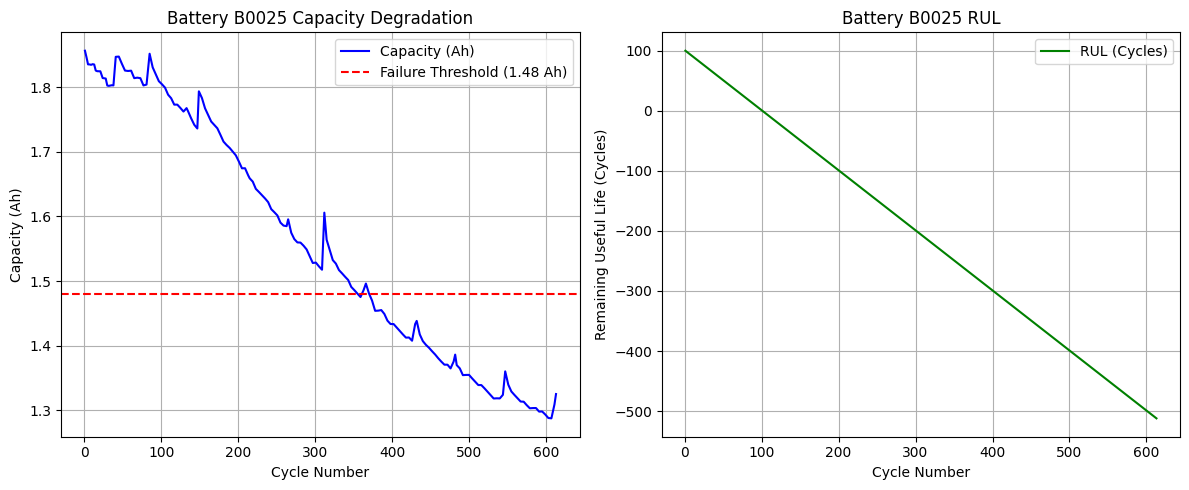

: 

In [ ]:
# Load the .mat file (adjust path to where you saved it)
file_path = '../data/raw/NASA/B0005.mat'  # Update this!
mat_data = sio.loadmat(file_path)
# Extract the battery data (usually under a key like 'B0005')
battery_data = mat_data['B0005'][0, 0]['cycle'][0]

cycles = []
capacities = []
for i, cycle in enumerate(battery_data):
    if cycle['type'][0] == 'discharge':
        cycles.append(i)
        raw_capacity = cycle['data']['Capacity']
        capacity_scalar = raw_capacity[0][0][0][0]  # Unwrap nested array
        capacities.append(capacity_scalar)

# Define failure threshold (80% of initial ~1.85 Ah)
failure_threshold = 1.48  # Adjust if needed
failure_cycle = -1
for i, cap in enumerate(capacities):
    if cap <= failure_threshold:
        failure_cycle = i
        break

if failure_cycle == -1:
    print("Battery didn't reach failure threshold in 80 cycles. Extend or adjust threshold.")
    failure_cycle = len(cycles)  # Use last cycle as proxy

# Calculate RUL for each cycle
ruls = [failure_cycle - i for i in cycles]

# Print stats
print(f"Loaded {len(cycles)} discharge cycles.")
print(f"Initial capacity: {capacities[0]:.3f} Ah")
print(f"Final capacity: {capacities[-1]:.3f} Ah")
print(f"Estimated failure cycle: {failure_cycle} (capacity ~{capacities[failure_cycle] if failure_cycle < len(capacities) else 'N/A'}:.3f Ah)")
print(f"RUL at cycle 0: {ruls[0]} cycles")

# Plot capacity and RUL
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cycles, capacities, 'b-', label='Capacity (Ah)')
plt.axhline(y=failure_threshold, color='r', linestyle='--', label='Failure Threshold (1.48 Ah)')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.title('Battery B0025 Capacity Degradation')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cycles, ruls, 'g-', label='RUL (Cycles)')
plt.xlabel('Cycle Number')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.title('Battery B0025 RUL')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
file_path = '../data/NASA/B0005.mat'  # Update this!
mat_data = sio.loadmat(file_path)
# Extract discharge data and verify cycle numbers
all_cycles = []
all_types = []
capacities = []  # Only for discharges, None for others
voltages = []
currents = []
temps = []

for i, cycle in enumerate(battery_data):
    all_cycles.append(i + 1)  # 1-based cycle number for all operations
    all_types.append(cycle['type'][0])
    data = cycle['data'] if 'data' in cycle.dtype.names else None
    if cycle['type'][0] == 'discharge' and data is not None:
        voltages.append(np.mean(data['Voltage_measured'][0]))
        currents.append(np.mean(data['Current_measured'][0]))
        temps.append(np.mean(data['Temperature_measured'][0]))
        raw_capacity = data['Capacity']
        capacity_scalar = raw_capacity[0][0][0][0]  # Unwrap nested array
        capacities.append(capacity_scalar)
    else:
        voltages.append(None)
        currents.append(None)
        temps.append(None if data is None else np.mean(data['Temperature_measured'][0] if 'Temperature_measured' in data.dtype.names else [24]))  # Default to 24°C if not available
        capacities.append(None)  # No capacity for charge/impedance

# Create DataFrame
df = pd.DataFrame({
    'Cycle': all_cycles,
    'Type': all_types,
    'Voltage (V)': voltages,
    'Current (A)': currents,
    'Temperature (°C)': temps,
    'Capacity (Ah)': capacities
})

# Interpolate capacity for non-discharge cycles (optional, for visualization)
df['Capacity (Ah) Interpolated'] = df['Capacity (Ah)'].interpolate(method='linear')

# Calculate RUL based on actual capacity (using 1.38 Ah threshold)
failure_threshold = 1.38
discharge_capacities = [c for c in capacities if c is not None]
discharge_cycles = [c for c, t in zip(all_cycles, all_types) if t == 'discharge']

failure_cycle = -1
for i, cap in enumerate(discharge_capacities):
    if cap <= failure_threshold:
        failure_cycle = discharge_cycles[i]
        break

if failure_cycle == -1:
    print("Battery didn't reach 1.38 Ah threshold. Using last discharge cycle as proxy.")
    failure_cycle = discharge_cycles[-1]

df['RUL (Cycles)'] = [failure_cycle - c if t == 'discharge' else None for c, t in zip(df['Cycle'], df['Type'])]
df['RUL (Cycles) Interpolated'] = df['RUL (Cycles)'].interpolate(method='linear')

# Print stats
print(f"Total cycles (all operations): {len(all_cycles)}")
print(f"Discharge cycles: {len(discharge_cycles)}")
print(f"Initial capacity (discharge): {discharge_capacities[0]:.3f} Ah if available")
print(f"Final capacity (discharge): {discharge_capacities[-1]:.3f} Ah if available")
if failure_cycle != -1:
    print(f"Failure cycle: {failure_cycle} (capacity ~{next(cap for cap, cyc in zip(discharge_capacities, discharge_cycles) if cyc == failure_cycle):.3f} Ah)")
else:
    print("No failure detected within discharge cycles.")

# Plot capacity and RUL
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['Cycle'], df['Capacity (Ah) Interpolated'], 'b-', label='Capacity (Ah) Interpolated', alpha=0.5)
plt.scatter(df[df['Type'] == 'discharge']['Cycle'], df[df['Type'] == 'discharge']['Capacity (Ah)'], 
            c='b', label='Capacity (Ah) - Discharge Only', zorder=5)
plt.axhline(y=failure_threshold, color='r', linestyle='--', label=f'Failure Threshold ({failure_threshold} Ah)')
for t in df['Type'].unique():
    plt.scatter(df[df['Type'] == t]['Cycle'], [np.nan] * len(df[df['Type'] == t]), 
                label=f'{t.capitalize()} Cycle', c='gray', alpha=0.3, s=50)
plt.xlabel('Cycle Number (All Operations)')
plt.ylabel('Capacity (Ah)')
plt.title('Battery B0005 Capacity Degradation (All Cycles)')
plt.grid(True)
plt.legend()
plt.xlim(1, len(all_cycles))

plt.subplot(1, 2, 2)
plt.plot(df['Cycle'], df['RUL (Cycles) Interpolated'], 'g-', label='RUL (Cycles) Interpolated', alpha=0.5)
plt.scatter(df[df['Type'] == 'discharge']['Cycle'], df[df['Type'] == 'discharge']['RUL (Cycles)'], 
            c='g', label='RUL (Cycles) - Discharge Only', zorder=5)
plt.xlabel('Cycle Number (All Operations)')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.title('Battery B0005 RUL (1.38 Ah)')
plt.grid(True)
plt.legend()
plt.xlim(1, len(all_cycles))

plt.tight_layout()
plt.show()
# Save DataFrame
df.to_csv('../data/NASA/preprocessed/B0005_processed.csv', index=False)
print("Data saved to B0005_processed.csv")

NameError: name 'sio' is not defined

In [ ]:


file_path = '../data/NASA/B0050.mat'  # Update this!
mat_data = sio.loadmat(file_path)
battery_data = mat_data['B0050'][0, 0]['cycle'][0]

# Extract discharge cycles and capacities
cycles = []
capacities = []
for i, cycle in enumerate(battery_data):
    if cycle['type'][0] == 'discharge':
        cycles.append(i + 1)  # 1-based cycle number (discharges only)
        raw_capacity = cycle['data']['Capacity']
        # Debug: Print raw capacity and cycle details
        print(f"Cycle {i + 1} - Type: {cycle['type'][0]}, Raw capacity: {raw_capacity}, Time: {cycle['time']}")
        capacity_scalar = raw_capacity[0][0][0][0]  # Unwrap nested array
        capacities.append(capacity_scalar)

# Define failure thresholds to test
failure_thresholds = [1.48, 1.38]  # Test both NASA norms
failure_cycles = {}

for thresh in failure_thresholds:
    failure_cycle = -1
    for i, cap in enumerate(capacities):
        if cap <= thresh:
            failure_cycle = cycles[i]
            break

    if failure_cycle == -1:
        print(f"Battery didn't reach {thresh} Ah threshold in {len(cycles)} cycles. Using last cycle as proxy.")
        failure_cycle = cycles[-1]

    failure_cycles[thresh] = failure_cycle
    ruls = [failure_cycle - c for c in cycles]

    # Print stats for each threshold
    print(f"\nThreshold {thresh} Ah:")
    print(f"Loaded {len(cycles)} discharge cycles.")
    print(f"Initial capacity: {capacities[0]:.3f} Ah")
    print(f"Final capacity: {capacities[-1]:.3f} Ah")
    print(f"Failure cycle: {failure_cycle} (capacity ~{capacities[cycles.index(failure_cycle)]:.3f} Ah)")
    print(f"RUL at cycle 1: {ruls[0]} cycles")

    # Plot capacity and RUL (discharges only, no xlim)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(cycles, capacities, 'b-', label='Capacity (Ah)')
    plt.axhline(y=thresh, color='r', linestyle='--', label=f'Failure Threshold ({thresh} Ah)')
    plt.xlabel('Cycle Number (Discharge Only)')
    plt.ylabel('Capacity (Ah)')
    plt.title('Battery B0005 Capacity Degradation')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cycles, ruls, 'g-', label='RUL (Cycles)')
    plt.xlabel('Cycle Number (Discharge Only)')
    plt.ylabel('Remaining Useful Life (Cycles)')
    plt.title(f'Battery B0005 RUL ({thresh} Ah)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Processing complete for B0005.")

Cycle 1 - Type: discharge, Raw capacity: [[array([[0.86314485]])]], Time: [[2010.       8.      23.      17.      51.       9.218]]
Cycle 5 - Type: discharge, Raw capacity: [[array([[1.64878961]])]], Time: [[2010.       8.      23.      22.      33.      35.875]]
Cycle 7 - Type: discharge, Raw capacity: [[array([[1.60163649]])]], Time: [[2.0100e+03 8.0000e+00 2.4000e+01 2.0000e+00 2.8000e+01 5.4312e+01]]
Cycle 9 - Type: discharge, Raw capacity: [[array([[1.55175648]])]], Time: [[2010.       8.      24.       6.      23.      38.343]]
Cycle 11 - Type: discharge, Raw capacity: [[array([[0.03255842]])]], Time: [[2010.       8.      26.      11.       4.       3.078]]
Cycle 15 - Type: discharge, Raw capacity: [[array([[2.64014912]])]], Time: [[2010.       8.      26.      16.      34.      25.921]]
Cycle 17 - Type: discharge, Raw capacity: [[array([[1.35902766]])]], Time: [[2010.       8.      26.      21.       7.      22.031]]
Cycle 19 - Type: discharge, Raw capacity: [[array([[1.3742172

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar (optional, install with `pip install tqdm`)

# Directory with NASA data (create if needed)
DATASET_PATH = '../data/NASA/'
OUTPUT_PATH = os.path.join(DATASET_PATH, 'preprocessed')
os.makedirs(OUTPUT_PATH, exist_ok=True)  # Ensure preprocessed folder exists

# Define capacity thresholds for RUL calculation
CAPACITY_THRESHOLDS = {
    "default": 1.38,  # 70% of nominal capacity (~1.97 Ah)
    "B0033-B0036": 1.6,  # 20% fade
    "B0041-B0044": 1.4  # 30% fade
}

# Function to determine remaining useful life (RUL)
def compute_rul(capacity_series, threshold):
    rul = []
    for i, cap in enumerate(capacity_series):
        if np.isnan(cap):
            rul.append(np.nan)
            continue
        future_cycles = np.where(capacity_series[i:] <= threshold)[0]
        rul.append(future_cycles[0] if len(future_cycles) > 0 else 0)
    return np.array(rul)

# Process each NASA battery
battery_files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".mat")]
for battery_file in tqdm(battery_files, desc="Processing NASA batteries"):
    battery_id = battery_file.split(".")[0]  # Extract battery ID from filename, e.g., 'B0005'
    file_path = os.path.join(DATASET_PATH, battery_file)
    if battery_id not in [f'B{i:04d}' for i in range(5, 57) if i not in list(range(8, 18)) + list(range(19, 25)) + [35, 37]]:
        print(f"Warning: {battery_id} not in expected range, skipping.")
        continue

    print(f"\nProcessing {battery_id}...")
    
    # Load .mat file
    mat_data = sio.loadmat(file_path)
    
    # Access the battery data (standard NASA structure, top-level battery ID)
    if battery_id in mat_data:
        battery_data = mat_data[battery_id][0, 0]
        cycle_data = battery_data["cycle"]  # Access cycles directly
    else:
        print(f"Warning: No battery data found for {battery_id}. Skipping.")
        continue

    # Extract discharge cycles only
    discharge_cycles = []
    capacities = []
    voltages = []
    currents = []
    temps = []

    # Track sequential discharge cycles
    discharge_count = 0
    print(f"Number of cycles: {len(cycle_data)}")
    for i, cycle in enumerate(tqdm(cycle_data, desc=f"Processing cycles for {battery_id}")):
        # Debug: Print cycle structure to identify issues
        cycle_type = 'unknown'
        try:
            # Direct access like the uploaded script, convert NumPy array to string
            if isinstance(cycle["type"], np.ndarray) and cycle["type"].size > 0:
                cycle_type = cycle["type"][0].item()  # Convert NumPy array to string
            elif isinstance(cycle["type"], str):
                cycle_type = cycle["type"]
            else:
                cycle_type = str(cycle["type"]) if cycle["type"] is not None else 'unknown'
        except (IndexError, AttributeError, TypeError) as e:
            print(f"Warning: Error accessing type at Cycle {i} - {e}, setting to 'unknown'")
            cycle_type = 'unknown'
        print(f"Cycle {i} structure: {cycle.dtype.names if hasattr(cycle, 'dtype') else 'No dtype'}, Type: {cycle_type}")
        
        if cycle_type.lower() == 'discharge':
            discharge_count += 1  # Increment for each discharge
            discharge_cycles.append(discharge_count)  # 1-based, sequential
            # Direct data access for named fields
            data = cycle["data"] if "data" in cycle.dtype.names else None
            
            if data is None:
                print(f"Warning: No data field in Cycle {discharge_count} for {battery_id}, skipping.")
                continue

            # Extract features, using named fields for Capacity, Voltage, Current, Temperature
            if 'Capacity' in data.dtype.names:
                raw_capacity = data['Capacity']
                # Debug: Print raw capacity structure and value
                print(f"Cycle {discharge_count} - Raw Capacity structure: {raw_capacity.dtype if hasattr(raw_capacity, 'dtype') else 'No dtype'}, Value: {raw_capacity}")
                try:
                    # Unwrap nested array (match B0005 structure)
                    if isinstance(raw_capacity, np.ndarray) and raw_capacity.size > 0:
                        capacity_scalar = raw_capacity[0][0][0][0] if len(raw_capacity.shape) > 1 else raw_capacity[0]
                    else:
                        capacity_scalar = np.nan
                        print(f"Warning: Invalid Capacity format at Cycle {discharge_count}, setting to NaN")
                    capacities.append(capacity_scalar)
                except (IndexError, ValueError) as e:
                    capacities.append(np.nan)
                    print(f"Warning: Error unwrapping Capacity at Cycle {discharge_count} - {e}, setting to NaN")

            if 'Voltage_measured' in data.dtype.names:
                raw_voltage = data['Voltage_measured']
                # Debug: Print raw voltage structure and value
                print(f"Cycle {discharge_count} - Raw Voltage_measured structure: {raw_voltage.dtype if hasattr(raw_voltage, 'dtype') else 'No dtype'}, Value: {raw_voltage}")
                try:
                    # Unwrap nested array (mean for multiple values, scalar for single)
                    if isinstance(raw_voltage, np.ndarray) and raw_voltage.size > 0:
                        voltage_scalar = np.mean(raw_voltage.flatten())  # Mean for array
                    else:
                        voltage_scalar = np.nan
                        print(f"Warning: Invalid Voltage_measured format at Cycle {discharge_count}, setting to NaN")
                    voltages.append(voltage_scalar)
                except (IndexError, ValueError) as e:
                    voltages.append(np.nan)
                    print(f"Warning: Error unwrapping Voltage_measured at Cycle {discharge_count} - {e}, setting to NaN")

            if 'Current_measured' in data.dtype.names:
                raw_current = data['Current_measured']
                # Debug: Print raw current structure and value
                print(f"Cycle {discharge_count} - Raw Current_measured structure: {raw_current.dtype if hasattr(raw_current, 'dtype') else 'No dtype'}, Value: {raw_current}")
                try:
                    # Unwrap nested array (mean for multiple values, scalar for single, negative for discharge)
                    if isinstance(raw_current, np.ndarray) and raw_current.size > 0:
                        current_scalar = np.mean(raw_current.flatten())  # Mean for array
                    else:
                        current_scalar = np.nan
                        print(f"Warning: Invalid Current_measured format at Cycle {discharge_count}, setting to NaN")
                    currents.append(-current_scalar)  # Keep negative for discharge, no scaling (amps)
                except (IndexError, ValueError) as e:
                    currents.append(np.nan)
                    print(f"Warning: Error unwrapping Current_measured at Cycle {discharge_count} - {e}, setting to NaN")

            if 'Temperature_measured' in data.dtype.names:
                raw_temp = data['Temperature_measured']
                # Debug: Print raw temperature structure and value
                print(f"Cycle {discharge_count} - Raw Temperature_measured structure: {raw_temp.dtype if hasattr(raw_temp, 'dtype') else 'No dtype'}, Value: {raw_temp}")
                try:
                    # Unwrap nested array (mean for multiple values, scalar for single)
                    if isinstance(raw_temp, np.ndarray) and raw_temp.size > 0:
                        temp_scalar = np.mean(raw_temp.flatten())  # Mean for array
                    else:
                        temp_scalar = np.nan
                        print(f"Warning: Invalid Temperature_measured format at Cycle {discharge_count}, setting to NaN")
                    temps.append(temp_scalar)
                except (IndexError, ValueError) as e:
                    temps.append(np.nan)
                    print(f"Warning: Error unwrapping Temperature_measured at Cycle {discharge_count} - {e}, setting to NaN")

    # Handle empty lists to prevent ValueError
    if not discharge_cycles:
        discharge_cycles = [np.nan]  # Default to NaN if no discharges found
        capacities = [np.nan]
        voltages = [np.nan]
        currents = [np.nan]
        temps = [np.nan]

    # Get initial capacity for SoH (use first valid capacity if initial isn't set)
    initial_capacity = next((c for c in capacities if not np.isnan(c)), np.nan)  # Infer from data
    if np.isnan(initial_capacity):
        print(f"Warning: No valid initial capacity for {battery_id}, using default 1.97 Ah (adjust based on data)")  # Use 1.97 Ah for B0005, adjust per battery
        initial_capacity = 1.97  # Default for B0005, adjust per battery
    print(f"Initial capacity for {battery_id}: {initial_capacity:.3f} Ah")

    # Calculate SoH (%) for each cycle
    soh = [(c / initial_capacity) * 100 if not np.isnan(c) else np.nan for c in capacities]

    # Calculate RUL (using 70% SoH threshold or specific fade, adjust per battery)
    failure_threshold = CAPACITY_THRESHOLDS.get("default")
    if any(battery_id.startswith(x) for x in ["B0033", "B0034", "B0036"]):  # Skip B0035 (gap)
        failure_threshold = CAPACITY_THRESHOLDS["B0033-B0036"]
    elif any(battery_id.startswith(x) for x in ["B0041", "B0042", "B0043", "B0044"]):
        failure_threshold = CAPACITY_THRESHOLDS["B0041-B0044"]

    ruls = compute_rul(np.array(capacities), failure_threshold)

    # Create DataFrame with cycle data
    df_processed = pd.DataFrame({
        'Cycle': discharge_cycles,
        'Voltage (V)': voltages,
        'Current (A)': currents,  # Negative for discharge, in amps
        'Temperature (°C)': temps,
        'Capacity (Ah)': capacities,
        'SoH (%)': soh,
        'RUL (Cycles)': ruls
    })

    # Handle NaN values (e.g., interpolate or drop if needed)
    if not df_processed.empty:
        df_processed = df_processed.interpolate(method='linear').bfill().ffill()
    else:
        df_processed = pd.DataFrame({
            'Cycle': [np.nan],
            'Voltage (V)': [np.nan],
            'Current (A)': [np.nan],
            'Temperature (°C)': [np.nan],
            'Capacity (Ah)': [np.nan],
            'SoH (%)': [np.nan],
            'RUL (Cycles)': [np.nan]
        })

    # Print stats
    print(f"\nBattery {battery_id} Stats (Threshold {failure_threshold:.3f} Ah, 70% SoH or fade):")
    print(f"Loaded {len(discharge_cycles)} discharge cycles.")
    if not np.isnan(initial_capacity) and capacities:
        print(f"Initial capacity: {capacities[0]:.3f} Ah")
        print(f"Final capacity: {capacities[-1]:.3f} Ah")
        print(f"Initial SoH: {soh[0]:.1f}%")
        print(f"Final SoH: {soh[-1]:.1f}%")
    else:
        print("No valid capacity data available.")
    if not np.isnan(failure_threshold) and cycles and len(capacities) > 0:
        failure_index = np.where(np.array(capacities) <= failure_threshold)[0]
        if len(failure_index) > 0:
            failure_cycle = cycles[failure_index[0]]
            failure_cap = capacities[failure_index[0]]
            failure_soh = soh[failure_index[0]] if not np.isnan(soh[failure_index[0]]) else np.nan
            print(f"Failure cycle (discharge): {failure_cycle} (capacity ~{failure_cap:.3f} Ah, SoH ~{failure_soh:.1f}%)")
    print(f"RUL at cycle 1: {ruls[0] if not np.isnan(ruls[0]) else 'N/A'} cycles")

    # Save DataFrame to CSV (ensure directory exists and file writes correctly)
    output_file = os.path.join(OUTPUT_PATH, f'{battery_id}_processed.csv')
    try:
        df_processed.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
        # Debug: Print the first few rows of the DataFrame to check content
        print(f"CSV content preview:\n{df_processed.head().to_string()}")
    except Exception as e:
        print(f"Error saving {output_file}: {e}")

print("All NASA batteries processed.")

Processing NASA batteries:   0%|          | 0/34 [00:00<?, ?it/s]


Processing B0005...
Number of cycles: 1


Processing NASA batteries:   0%|          | 0/34 [00:00<?, ?it/s]

Cycle 0 structure: ('type', 'ambient_temperature', 'time', 'data'), Type: charge
Initial capacity for B0005: 1.970 Ah

Battery B0005 Stats (Threshold 1.380 Ah, 70% SoH or fade):
Loaded 1 discharge cycles.
Initial capacity: nan Ah
Final capacity: nan Ah
Initial SoH: nan%
Final SoH: nan%


NameError: name 'cycles' is not defined

In [1]:
import os
import numpy as np
import scipy.io as sio
import pandas as pd
from tqdm import tqdm

# Define paths
DATASET_PATH = "../data/NASA/"
OUTPUT_PATH = "../data/NASA/preprocessing/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Define capacity thresholds for RUL calculation
CAPACITY_THRESHOLDS = {
    "default": 1.38,  # 70% of nominal capacity
    "B0033-B0036": 1.6,  # 20% fade
    "B0041-B0044": 1.4  # 30% fade
}
NASA_CAPACITY_NOMINAL = 2.0  # Ah (approximate value for NASA batteries)

# Function to determine remaining useful life (RUL)
def compute_rul(capacity_series, threshold):
    rul = []
    for i, cap in enumerate(capacity_series):
        future_cycles = np.where(capacity_series[i:] <= threshold)[0]
        rul.append(future_cycles[0] if len(future_cycles) > 0 else 0)
    return np.array(rul)

# Function to process a single battery dataset
def process_battery(file_path, battery_id):
    print(f"Processing {battery_id}...")
    
    # Load .mat file
    mat_data = sio.loadmat(file_path)
    
    # Extract cycle data
    battery_data = mat_data[battery_id][0, 0]
    cycles = battery_data["cycle"]
    
    # Initialize lists for extracted data
    cycle_nums, voltages, currents, temperatures, capacities, soh_values = [], [], [], [], [], []
    
    # Iterate over all cycles
    for cycle in tqdm(cycles):
        cycle_type = cycle["type"][0] if isinstance(cycle["type"], np.ndarray) else cycle["type"]
        
        # Only process discharge cycles
        if cycle_type != "discharge":
            continue
        
        cycle_num = cycle["index"][0][0]
        voltage = cycle["data"]["Voltage_measured"].flatten()
        current = cycle["data"]["Current_measured"].flatten()
        temperature = cycle["data"]["Temperature_measured"].flatten()
        
        # Extract discharge capacity
        try:
            capacity = cycle["data"]["Capacity"][0][0][0][0]
        except (KeyError, IndexError):
            continue  # Skip if capacity extraction fails
        
        cycle_nums.append(cycle_num)
        voltages.append(np.mean(voltage))  # Store mean voltage per cycle
        currents.append(np.mean(current))  # Store mean current per cycle
        temperatures.append(np.mean(temperature))  # Store mean temperature per cycle
        capacities.append(capacity)
        soh_values.append((capacity / capacities[0]) * 100)  # SoH in %
    
    # Convert to DataFrame
    df = pd.DataFrame({
        "Cycle": cycle_nums,
        "Voltage": voltages,
        "Current": currents,
        "Temperature": temperatures,
        "Capacity": capacities,
        "Normalized_Capacity": [cap / NASA_CAPACITY_NOMINAL for cap in capacities],
        "SoH": soh_values
    })
    
    # Determine capacity threshold based on battery ID
    threshold = CAPACITY_THRESHOLDS.get("default")
    if any(battery_id.startswith(x) for x in ["B0033", "B0034", "B0035", "B0036"]):
        threshold = CAPACITY_THRESHOLDS["B0033-B0036"]
    elif any(battery_id.startswith(x) for x in ["B0041", "B0042", "B0043", "B0044"]):
        threshold = CAPACITY_THRESHOLDS["B0041-B0044"]
    
    # Compute RUL
    df["RUL"] = compute_rul(df["Capacity"].values, threshold)
    
    # Add metadata columns
    df["Source"] = "NASA"
    df["Battery_ID"] = battery_id
    
    # Save to CSV
    output_file = os.path.join(OUTPUT_PATH, f"{battery_id}_processed.csv")
    df.to_csv(output_file, index=False)
    print(f"Processed data saved to {output_file}")

# Process all batteries
if __name__ == "__main__":
    battery_files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".mat")]
    print(battery_files)
    for battery_file in tqdm(battery_files, desc="Processing Batteries"):
        battery_id = battery_file.split(".")[0]  # Extract battery ID from filename
        process_battery(os.path.join(DATASET_PATH, battery_file), battery_id)

    print("NASA dataset preprocessing complete!")


['B0005.mat', 'B0006.mat', 'B0007.mat', 'B0018.mat', 'B0025.mat', 'B0026.mat', 'B0027.mat', 'B0028.mat', 'B0029.mat', 'B0030.mat', 'B0031.mat', 'B0032.mat', 'B0033.mat', 'B0034.mat', 'B0036.mat', 'B0038.mat', 'B0039.mat', 'B0040.mat', 'B0041.mat', 'B0042.mat', 'B0043.mat', 'B0044.mat', 'B0045.mat', 'B0046.mat', 'B0047.mat', 'B0048.mat', 'B0049.mat', 'B0050.mat', 'B0051.mat', 'B0052.mat', 'B0053.mat', 'B0054.mat', 'B0055.mat', 'B0056.mat']


Processing Batteries:   0%|          | 0/34 [00:00<?, ?it/s]

Processing B0005...


Processing Batteries:   3%|▎         | 1/34 [00:00<00:06,  4.94it/s]

Processed data saved to ../data/NASA/preprocessing/B0005_processed.csv
Processing B0006...


Processing Batteries:   6%|▌         | 2/34 [00:00<00:06,  5.05it/s]

Processed data saved to ../data/NASA/preprocessing/B0006_processed.csv
Processing B0007...


Processing Batteries:   9%|▉         | 3/34 [00:00<00:06,  4.96it/s]

Processed data saved to ../data/NASA/preprocessing/B0007_processed.csv
Processing B0018...


Processing Batteries:  12%|█▏        | 4/34 [00:00<00:05,  5.95it/s]

Processed data saved to ../data/NASA/preprocessing/B0018_processed.csv
Processing B0025...


100%|██████████| 1/1 [00:00<?, ?it/s]


Processed data saved to ../data/NASA/preprocessing/B0025_processed.csv
Processing B0026...


100%|██████████| 1/1 [00:00<?, ?it/s]


Processed data saved to ../data/NASA/preprocessing/B0026_processed.csv
Processing B0027...


Processing Batteries:  21%|██        | 7/34 [00:00<00:02, 11.22it/s]

Processed data saved to ../data/NASA/preprocessing/B0027_processed.csv
Processing B0028...


100%|██████████| 1/1 [00:00<?, ?it/s]


Processed data saved to ../data/NASA/preprocessing/B0028_processed.csv
Processing B0029...


100%|██████████| 1/1 [00:00<?, ?it/s]


Processed data saved to ../data/NASA/preprocessing/B0029_processed.csv
Processing B0030...


Processing Batteries:  29%|██▉       | 10/34 [00:00<00:01, 14.67it/s]

Processed data saved to ../data/NASA/preprocessing/B0030_processed.csv
Processing B0031...


100%|██████████| 1/1 [00:00<00:00, 995.09it/s]


Processed data saved to ../data/NASA/preprocessing/B0031_processed.csv
Processing B0032...


100%|██████████| 1/1 [00:00<?, ?it/s]


Processed data saved to ../data/NASA/preprocessing/B0032_processed.csv
Processing B0033...


Processing Batteries:  35%|███▌      | 12/34 [00:01<00:02,  9.68it/s]


ValueError: no field of name index